In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

repo_root = os.path.abspath(os.path.join(os.getcwd(), '../Detector_Classes'))
if repo_root not in sys.path:
    sys.path.append(repo_root)

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_efficiency_1d, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [3]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 5  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 5  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 0.2  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'rd5_grid_saral_1_co2_cosmic_10-30-25'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'quick_test'

det_single = 'rd5_grid_saral_1'

# file_nums = list(range(0, 3))
# file_nums = list(range(0, 109))
file_nums = [0]
# file_nums = 'all'

noise_sigma = 4
spark_filter_sigma = 10

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector
# realign_dream = False  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [15, 15]  # mm range to search for optimal z position
z_rot_align_range = [-2, 2]

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [4]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums, chi2_cut=1.5)
ray_data.remove_duplicate_events()
print(f'{len(ray_data.ray_data)} rays')

Getting ray data...


100%|██████████| 3/3 [00:00<00:00, 66.70it/s]

Cutting on detector size: 13805 / 27642 tracks remain, 49.94%
Pre-chi2 cut, Found 13883 events with 0 good tracks (50.22%), 46 events with >1 good tracks (0.17%)
Found 20068 events with 0 good tracks (72.60%), 0 events with >1 good tracks (0.00%)
Removing duplicate events: 128 duplicates found of 7574.
7574 rays


Getting no cut ray data...


100%|██████████| 3/3 [00:00<00:00, 52.49it/s]


Removing duplicate events: 1695 duplicates found of 27642.
27642 rays, fraction remaining: 27.40%


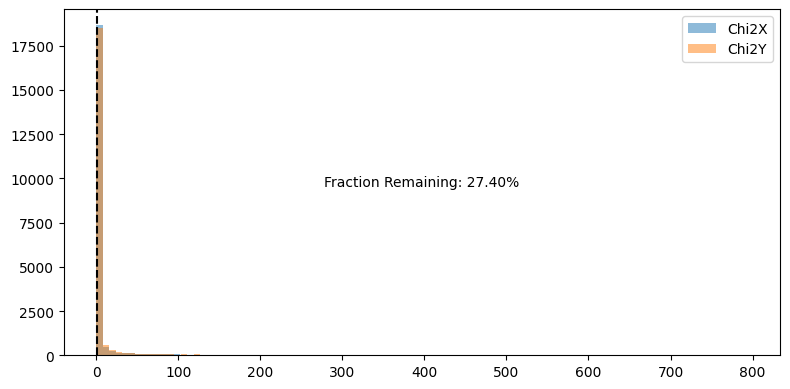

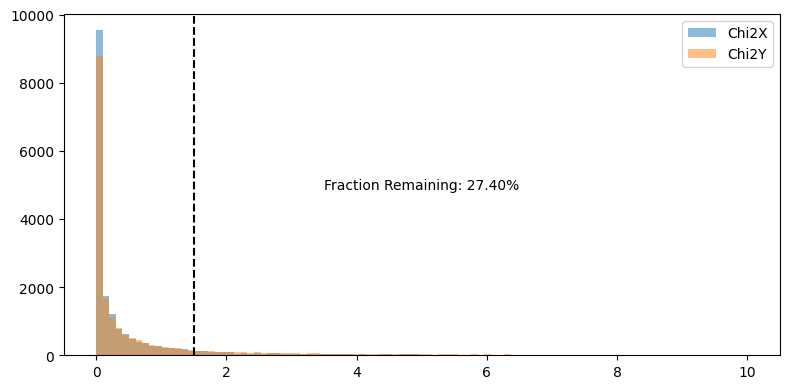

In [5]:
print(f'Getting no cut ray data...')
ray_data_no_cut = M3RefTracking(m3_dir, single_track=False, file_nums=file_nums)
ray_data_no_cut.remove_duplicate_events()
fraction_remaining = len(ray_data.ray_data) / len(ray_data_no_cut.ray_data)
print(f'{len(ray_data_no_cut.ray_data)} rays, fraction remaining: {fraction_remaining * 100:.2f}%')

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2X'], axis=1), bins=100, alpha=0.5, label='Chi2X')
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2Y'], axis=1), bins=100, alpha=0.5, label='Chi2Y')
ax.axvline(ray_data_no_cut.chi2_cut, color='black', ls='--')
ax.annotate(f'Fraction Remaining: {fraction_remaining * 100:.2f}%', (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
ax.legend()
fig.tight_layout()

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2X'], axis=1), bins=np.linspace(0, 10, 100), alpha=0.5, label='Chi2X')
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2Y'], axis=1), bins=np.linspace(0, 10, 100), alpha=0.5, label='Chi2Y')
ax.axvline(ray_data_no_cut.chi2_cut, color='black', ls='--')
ax.annotate(f'Fraction Remaining: {fraction_remaining * 100:.2f}%', (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
ax.legend()
fig.tight_layout()

In [6]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [7]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')

det.load_dream_data(data_dir, ped_dir, noise_sigma, file_nums, chunk_size, hist_raw_amps=True, save_waveforms=False, waveform_fit_func='parabola_vectorized')
print(f'Hits shape: {det.dream_data.hits.shape}')

Found 2 groups in detector map
FEU Num: 6
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 500, 'resist_1': 500, 'resist_2': 500}
Ped files found: ['CosTb_quick_test_pedthr_251030_12H22_000_06_decoded_array.root', 'CosTb_quick_test_pedthr_251030_12H32_000_06_decoded_array.root']
Reading in data...
Getting sub chunk 1/5, events: 0-339 of 1695


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Read in data shape: (339, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 1129.63it/s]


Fitting time: 0.01278829574584961 s
Processed sub-chunk 1/5
Getting sub chunk 2/5, events: 339-678 of 1695


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Read in data shape: (339, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 1327.91it/s]


Fitting time: 0.015755176544189453 s
Processed sub-chunk 2/5
Getting sub chunk 3/5, events: 678-1017 of 1695


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Read in data shape: (339, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 1513.33it/s]


Fitting time: 0.013327836990356445 s
Processed sub-chunk 3/5
Getting sub chunk 4/5, events: 1017-1356 of 1695


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Read in data shape: (339, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 1006.79it/s]


Fitting time: 0.013879060745239258 s
Processed sub-chunk 4/5
Getting sub chunk 5/5, events: 1356-1695 of 1695


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Read in data shape: (339, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 3154.29it/s]


Fitting time: 0.01770162582397461 s
Processed sub-chunk 5/5
Processed chunk 1/2
Getting sub chunk 1/5, events: 0-5189 of 25947


100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


Read in data shape: (5189, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 43.92it/s]

Fitting time: 0.19073891639709473 s
Processed sub-chunk 1/5
Getting sub chunk 2/5, events: 5189-10378 of 25947



100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


Read in data shape: (5189, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 53.90it/s]


Fitting time: 0.20261263847351074 s
Processed sub-chunk 2/5
Getting sub chunk 3/5, events: 10378-15568 of 25947


100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


Read in data shape: (5190, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 59.60it/s]


Fitting time: 0.1560680866241455 s
Processed sub-chunk 3/5
Getting sub chunk 4/5, events: 15568-20757 of 25947


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


Read in data shape: (5189, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 62.60it/s]


Fitting time: 0.18357467651367188 s
Processed sub-chunk 4/5
Getting sub chunk 5/5, events: 20757-25947 of 25947


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


Read in data shape: (5190, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 58.56it/s]


Fitting time: 0.2243938446044922 s
Processed sub-chunk 5/5
Processed chunk 2/2
Getting hits...
Hits shape: (27642, 256)


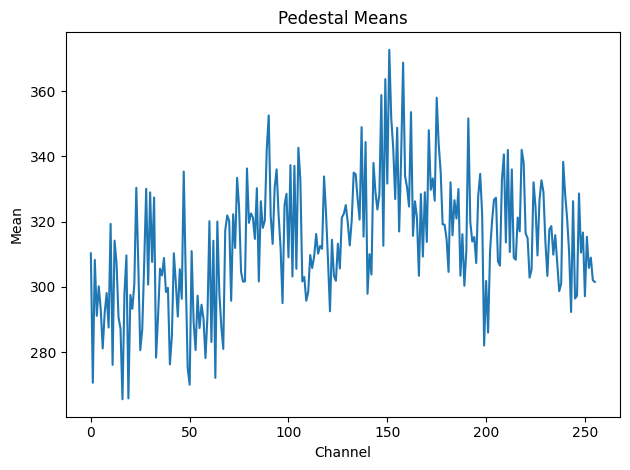

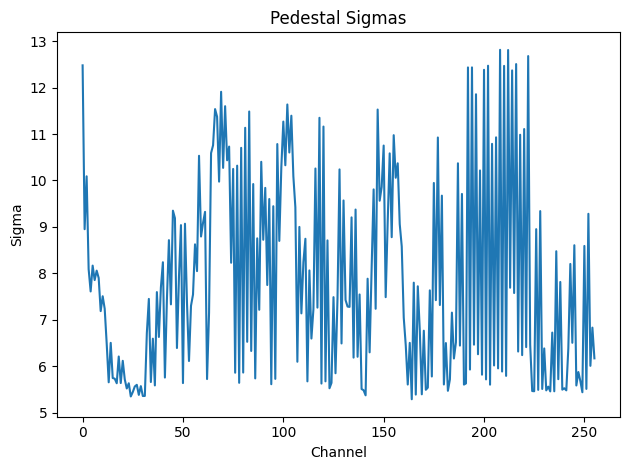

In [8]:
det.dream_data.plot_pedestals()

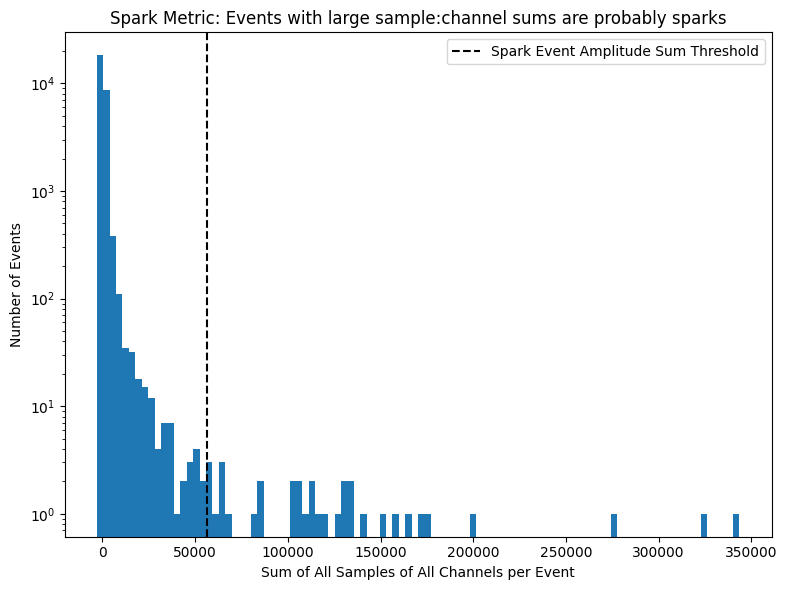

In [9]:
spark_mask = det.dream_data.filter_sparks(spark_filter_sigma=spark_filter_sigma, filter=False)

/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:855: RuntimeWarning: All-NaN slice encountered
  event_max_amps = np.nanmax(self.data_amps, axis=1)


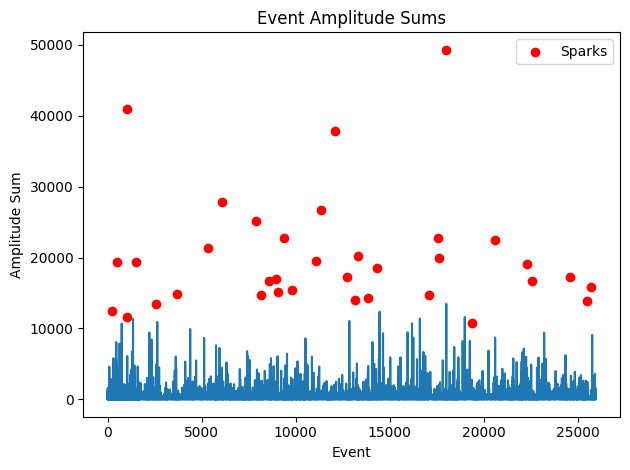

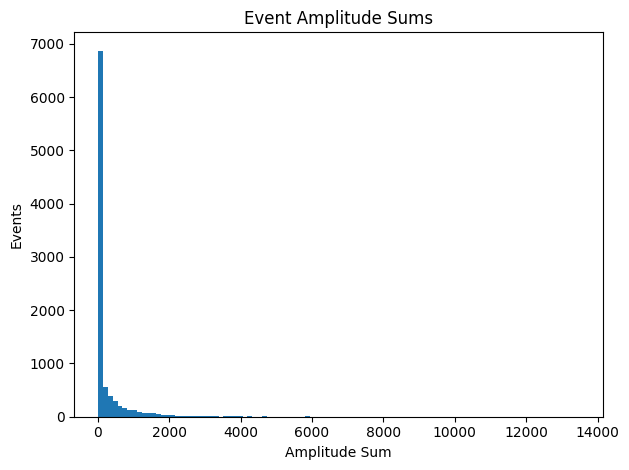

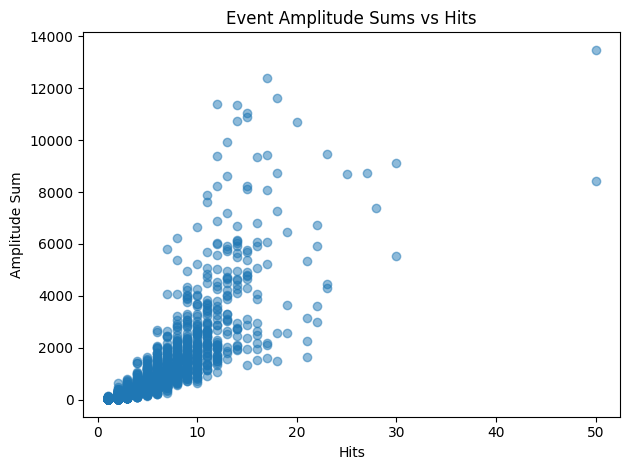

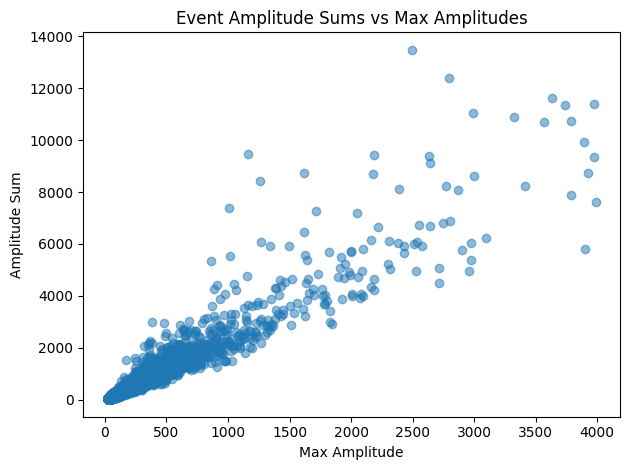

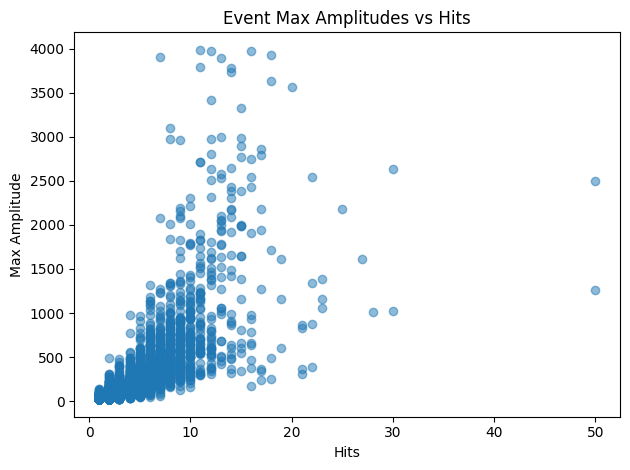

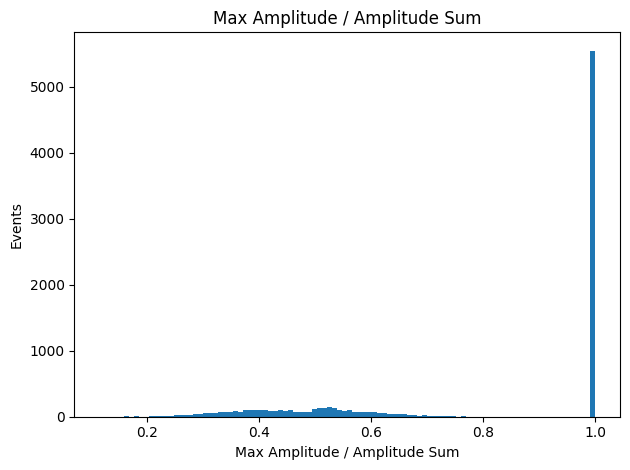

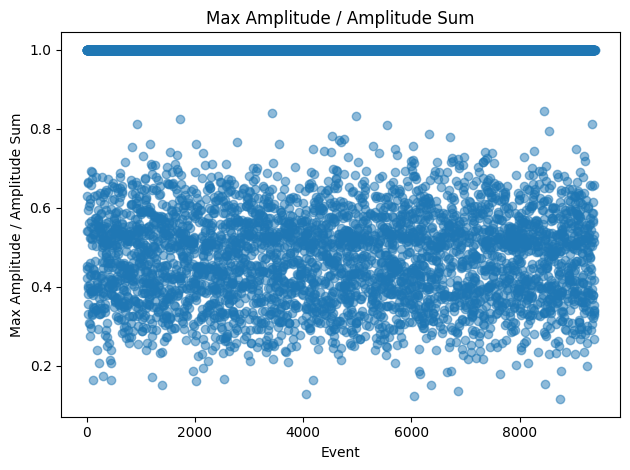

In [10]:
det.dream_data.plot_noise_metric(spark_mask)

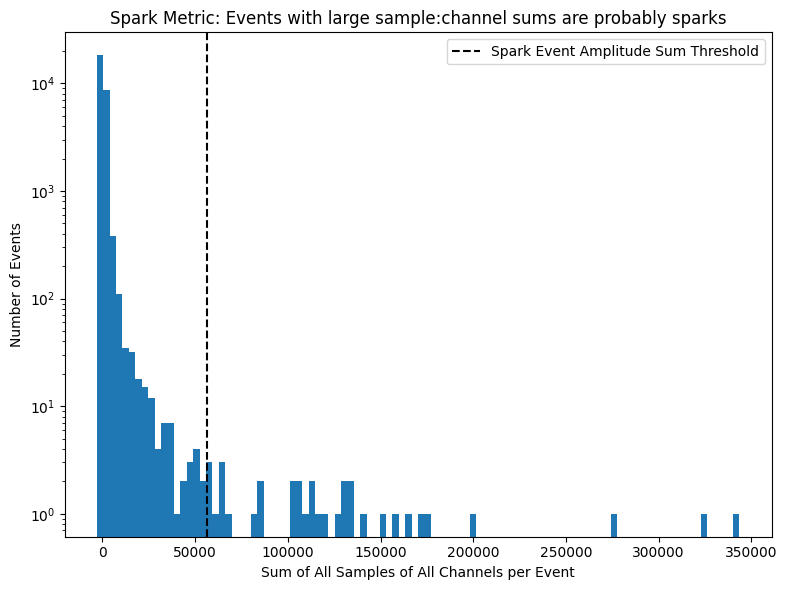

In [11]:
spark_mask = det.dream_data.filter_sparks(spark_filter_sigma=spark_filter_sigma, filter=True)

Connector 1 Dead Strips: []
Connector 2 Dead Strips: []
Connector 3 Dead Strips: []
Connector 4 Dead Strips: []


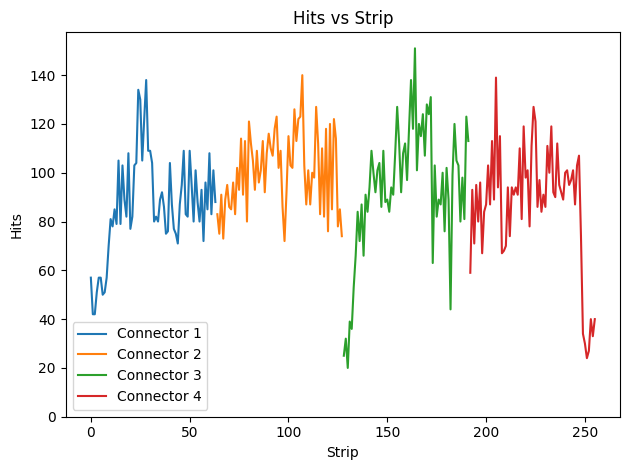

In [12]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

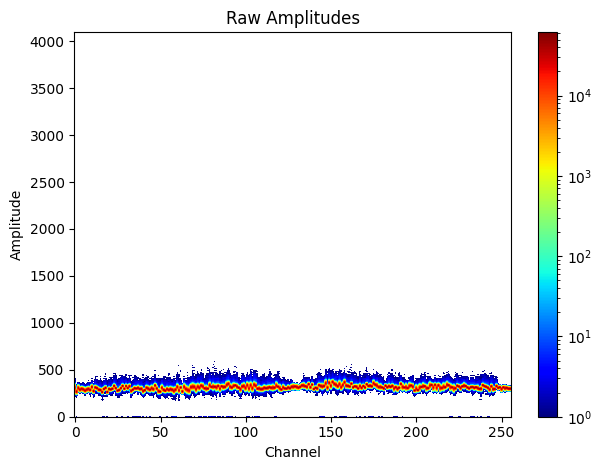

In [13]:
det.dream_data.plot_raw_amps_2d_hist()

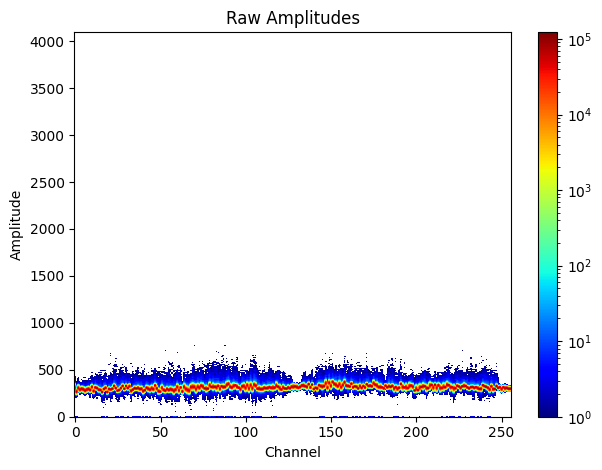

In [14]:
det.dream_data.plot_raw_amps_2d_hist(combine_y=2)

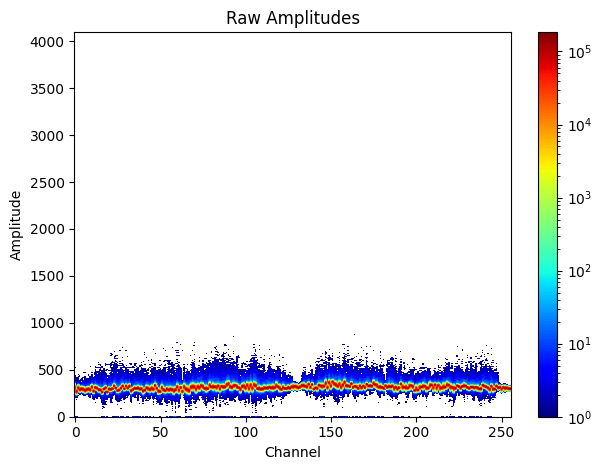

In [15]:
det.dream_data.plot_raw_amps_2d_hist(combine_y=3)

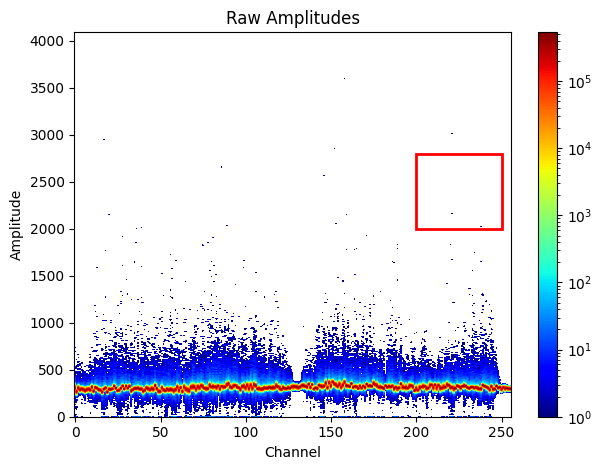

In [16]:
channel_range = (200, 250)
amplitude_range = (2000, 2800)
det.dream_data.plot_raw_amps_2d_hist(combine_y=10)

# Add a rectangle around channel/amplitude range
rect = plt.Rectangle((channel_range[0], amplitude_range[0]), channel_range[-1] - channel_range[0], amplitude_range[-1] - amplitude_range[0], fill=False, color='red', linewidth=2)
plt.gca().add_patch(rect)

In [17]:
det.make_sub_detectors()

In [51]:
print(len(det.dream_data.event_nums))
print(len(det.x_hits))
print(type(det.x_hits))
print(det.x_hits.shape)
any_x_hits = np.any(det.x_hits, axis=1)
any_y_hits = np.any(det.y_hits, axis=1)
any_x_and_y_hits = any_x_hits * any_y_hits
print(f'x_hit events: {np.sum(any_x_hits)}')
print(f'y_hit events: {np.sum(any_y_hits)}')
print(f'x_and_y_hits: {np.sum(any_x_and_y_hits)}')
# for sub_det in det.sub_detectors:
#     print(len(sub_det.x_largest_cluster_centroids))
#     print(len(sub_det.y_largest_cluster_centroids))

27607
27607
<class 'numpy.ndarray'>
(27607, 128)
x_hit events: 6311
y_hit events: 6432
x_and_y_hits: 3355


In [57]:
print(det.dream_data.event_nums.size)
print(det.get_n_x_and_y_hit_events())
print(det.get_n_x_and_y_hit_events(n_hits_per_orientation=2))

27607
3355
1894


7067392
7067392


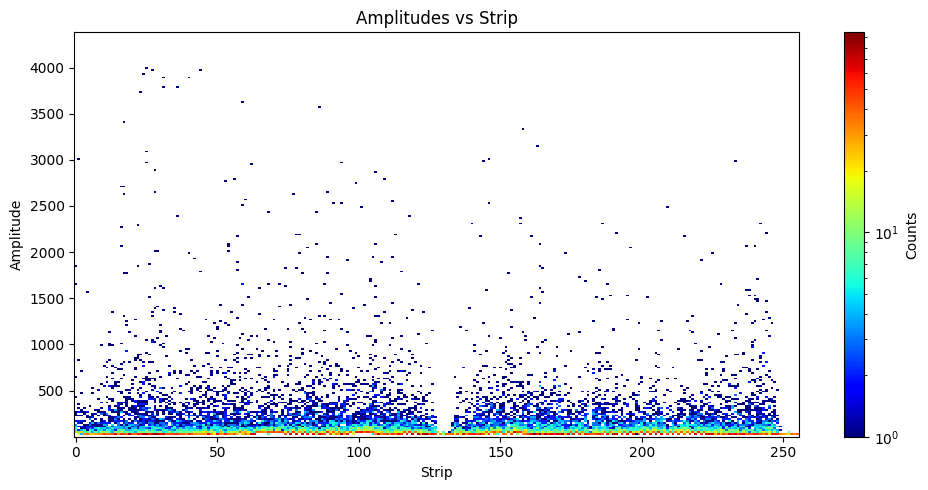

In [18]:
det.dream_data.plot_amplitudes_vs_strip()

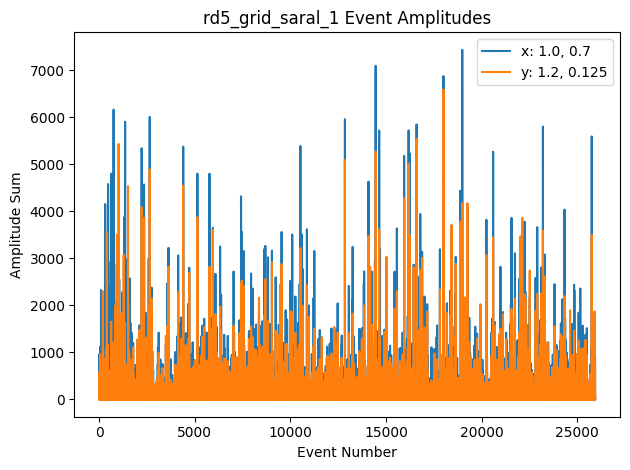

In [19]:
# det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

# if realign_dream:
#     det.center[2] = 722
#     det.add_rotation(90, 'z')

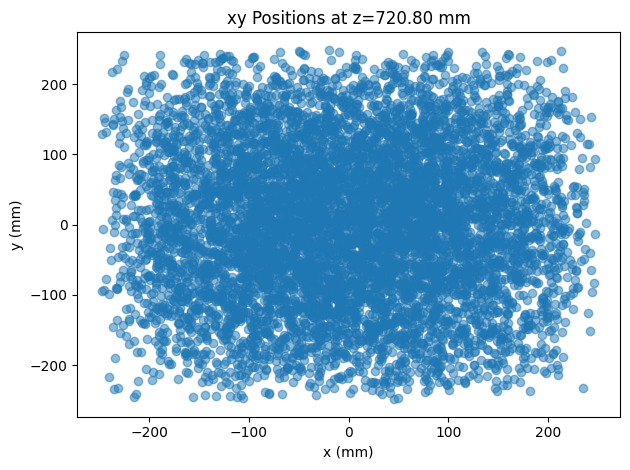

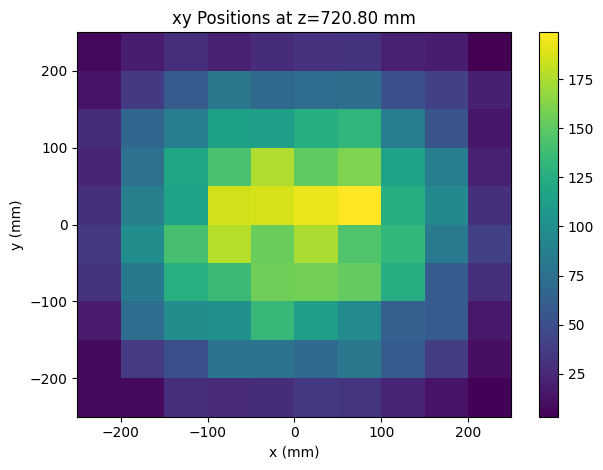

In [20]:
ray_data.plot_xy(det.center[2], plt_type='both', bins=10)

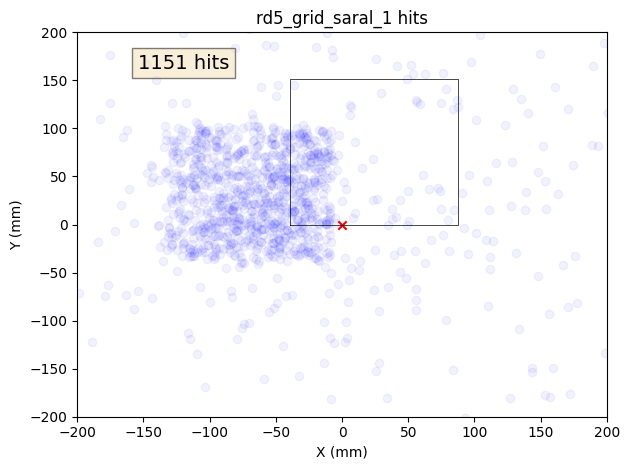

In [21]:
plot_ray_hits_2d(det, ray_data)

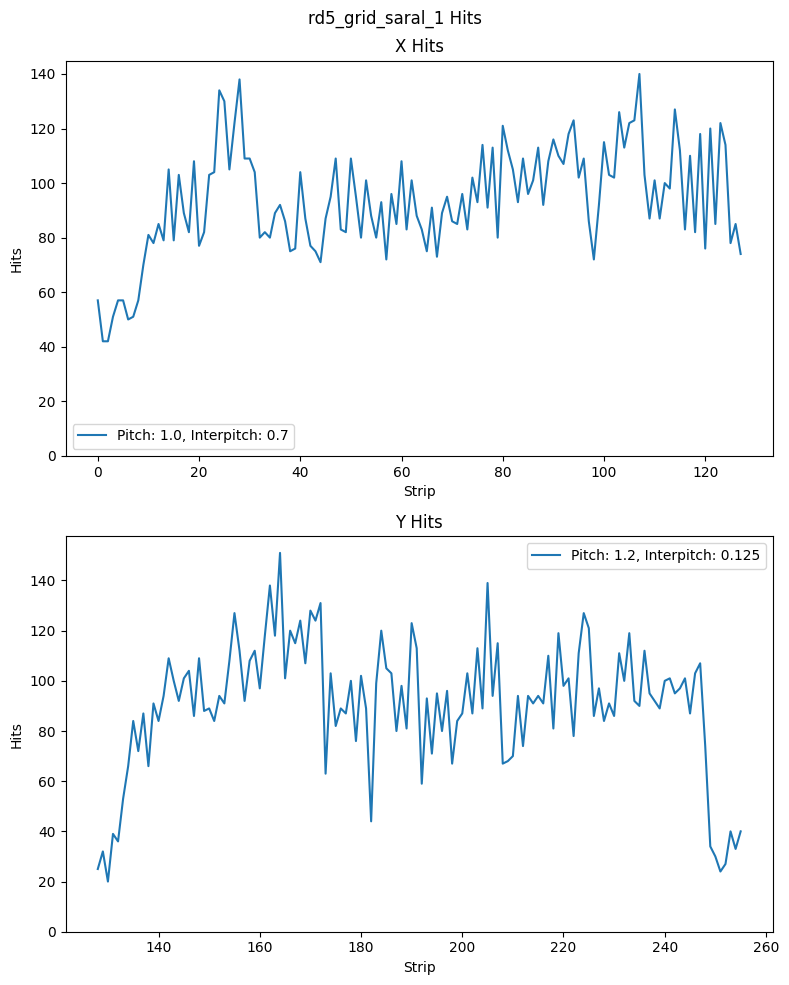

In [22]:
det.plot_hits_1d()

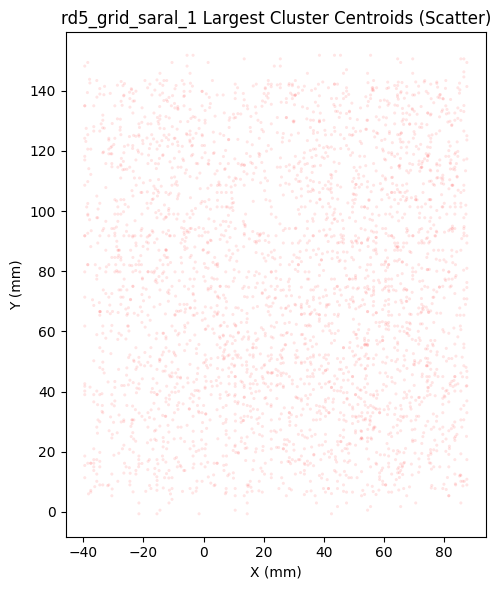

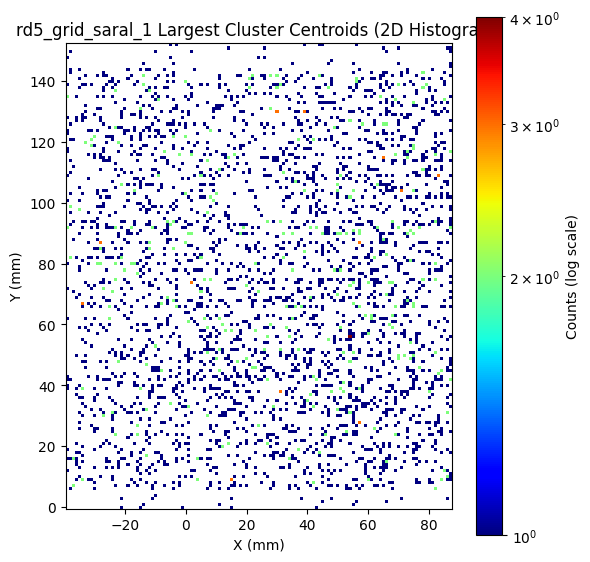

In [23]:
det.plot_centroids_2d()

sub_triggers shape: 3234, x_rays shape: 1151, y_rays shape: 1151, event_num_rays shape: 1151
Centroids shape: (1117, 3), x_rays shape: (1151,), y_rays shape: (1151,)
Missing in rays: [3.0000e+00 5.0000e+00 8.0000e+00 ... 2.5932e+04 2.5935e+04 2.5938e+04]
Missing in subs: []
Unique sub triggers: 3234 of 3234
Unique event triggers: 1117 of 1151
34 triggers appear more than once
Duplicate triggers: [   2   22  162  301  317  334  413  434  521  523  620  719  754  918
  925 1071 1075 1112 1122 1138 1205 1218 1277 1370 1489 1507 1542 1551
 1563 1580 1639 1655 1659 1676]
z: 705.8
sub_triggers shape: 3234, x_rays shape: 1151, y_rays shape: 1151, event_num_rays shape: 1151
Centroids shape: (1117, 3), x_rays shape: (1151,), y_rays shape: (1151,)
Missing in rays: [3.0000e+00 5.0000e+00 8.0000e+00 ... 2.5932e+04 2.5935e+04 2.5938e+04]
Missing in subs: []
Unique sub triggers: 3234 of 3234
Unique event triggers: 1117 of 1151
34 triggers appear more than once
Duplicate triggers: [   2   22  162  30

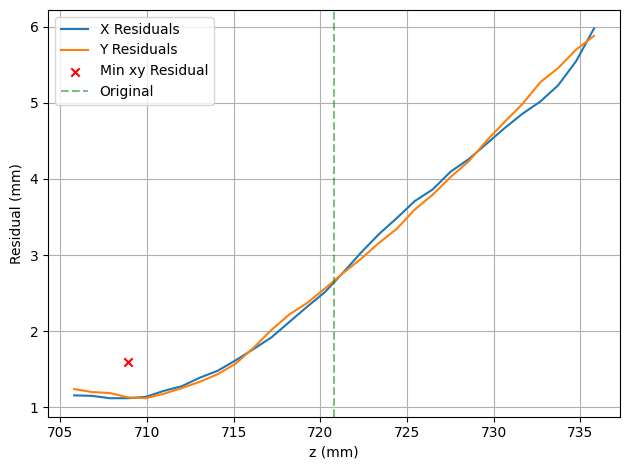

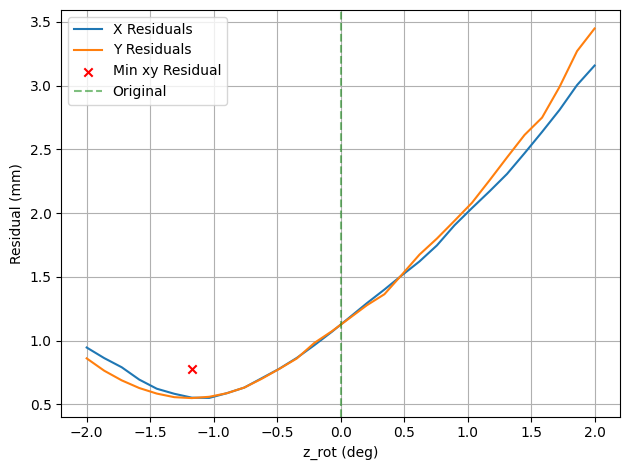

In [24]:
z_orig = det.center[2]
x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    align_dream(det, ray_data, z_align_range, z_rot_align_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

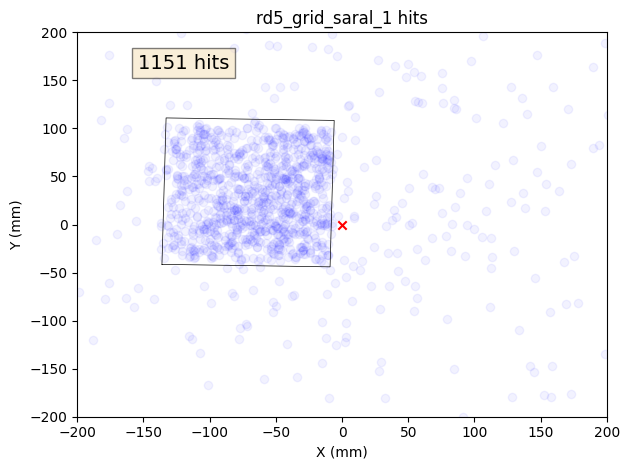

In [25]:
plot_ray_hits_2d(det, ray_data)

Pre-filtered rays: 7574
All rays: 1766
Bad event num indices: [0 1]
Bad event num indices: [22 23]
Bad event num indices: [22 23]
Bad event num indices: [46 47]
Bad event num indices: [49 50]
Bad event num indices: [57 58]
Bad event num indices: [69 70]
Bad event num indices: [79 80]
Bad event num indices: [81 82]
Bad event num indices: [81 82]
Bad event num indices: [101 102]
Bad event num indices: [105 106]
Bad event num indices: [123 124]
Bad event num indices: [126 127]
Bad event num indices: [149 150]
Bad event num indices: [151 152]
Bad event num indices: [154 155]
Bad event num indices: [157 158]
Bad event num indices: [163 164]
Bad event num indices: [163 164]
Bad event num indices: [172 173]
Bad event num indices: [176 177]
Bad event num indices: [186 187]
Bad event num indices: [186 187]
Bad event num indices: [200 201]
Bad event num indices: [214 215]
Bad event num indices: [218 219]
Bad event num indices: [223 224]
Bad event num indices: [228 229]
Bad event num indices: [23

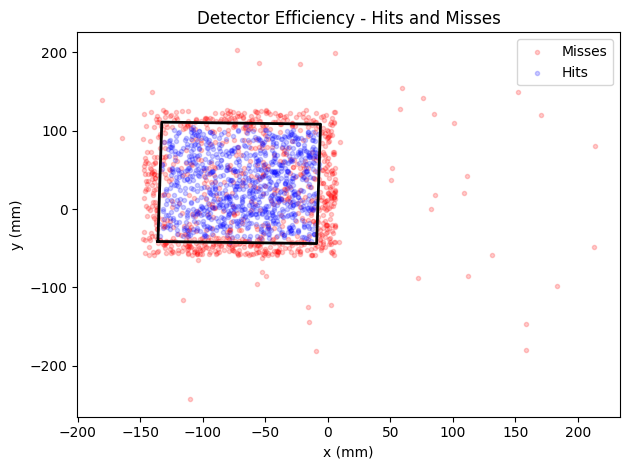

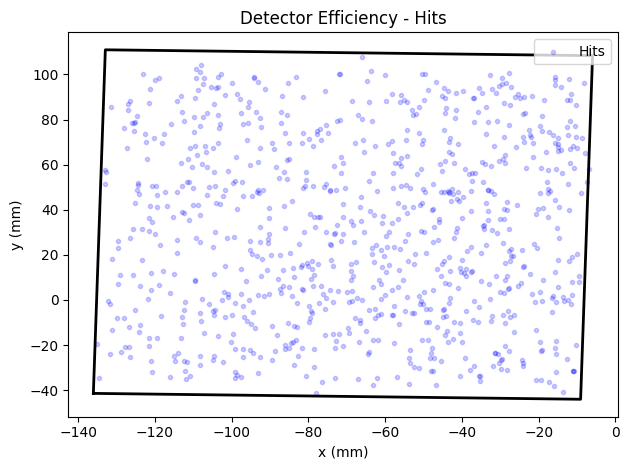

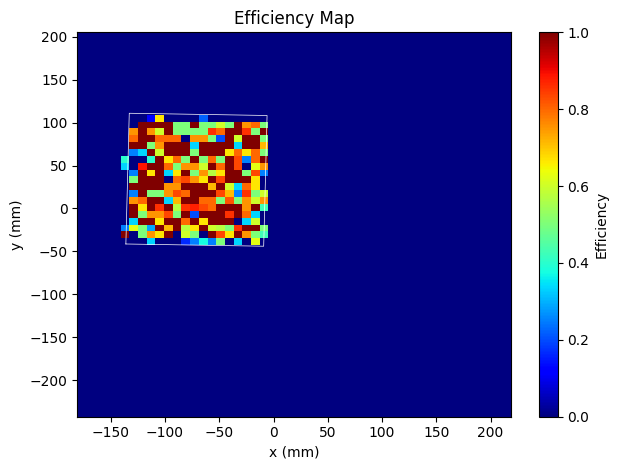

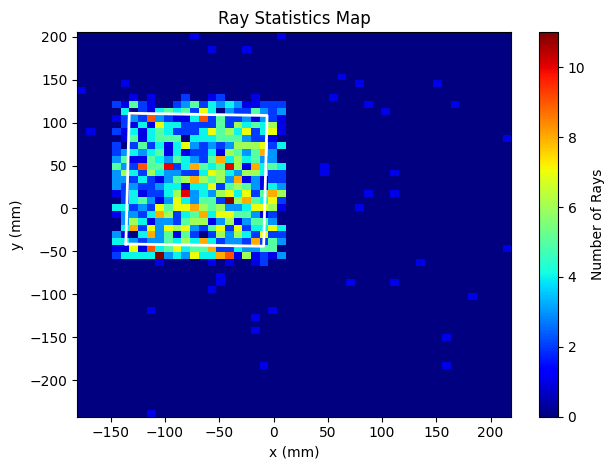

In [26]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2, grid_size=8)

In [ ]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
pitches, x_means, x_errs, y_means, y_errs = [], [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=-2)
    print(f'Rays in sub-detector {sub_det.sub_index}: {len(x_rays_in)}, total rays: {len(x_rays)}')
    x_mean, y_mean, x_err, y_err = sub_det.plot_cluster_sizes(event_nums=event_num_rays_in)
    pitches.append(sub_det.x_interpitch)
    x_means.append(x_mean)
    x_errs.append(x_err)
    y_means.append(y_mean)
    y_errs.append(y_err)

In [27]:
det.get_det_clusters()

In [28]:
get_efficiency_1d(det, ray_data, plot=True, in_det=False, tolerance=0.2, grid_size=2)

Pre-filtered rays: 7574
All rays: 7574


ValueError: operands could not be broadcast together with shapes (2019,) (2018,) 

In [ ]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2)

In [ ]:
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

New stuff above

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(pitches, x_means, yerr=x_errs, fmt='o', capsize=5, label='X')
ax.errorbar(pitches, y_means, yerr=y_errs, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
ax.plot(pitches, x_means, 'o', label='X')
ax.plot(pitches, y_means, 'o', label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [ ]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)

In [ ]:
scan_xs = np.arange(-100, 0, 1.0)
scan_ys = np.arange(-60, 100, 1.0)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 10  # mm
min_events = 30
# res_range = [160, 810]  # μm
# mean_range = [-200, 210]  # μm
res_range = None  # μm
mean_range = None  # μm

scan_resolutions_x, scan_means_x, events_x = get_circle_scan(np.array(x_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_x, scan_means_x, scan_xs, scan_ys, scan_events=events_x, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='X (Top) Spatial Resolution', mean_title='X (Top) Mean Residual', res_range=res_range, mean_range=mean_range)

In [ ]:
scan_resolutions_y, scan_means_y, events_y = get_circle_scan(np.array(y_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_y, scan_means_y, scan_xs, scan_ys, scan_events=events_y, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='Y (Bottom) Spatial Resolution', mean_title='Y (Bottom) Mean Residual', res_range=res_range, mean_range=mean_range)

In [ ]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)
scan_radius = 10
min_events = 20
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_sizes_all, y_sizes_all, x_rays_cluster_sizes, y_rays_cluster_sizes = [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=0)
    x_sizes, y_sizes, ray_mask = sub_det.get_cluster_sizes(largest=True, event_nums=event_num_rays_in, return_ray_mask=True)
    x_sizes_all.extend(x_sizes)
    y_sizes_all.extend(y_sizes)
    x_rays_cluster_sizes.extend(x_rays_in[ray_mask])
    y_rays_cluster_sizes.extend(y_rays_in[ray_mask])
scan_resolutions_csx, scan_means_csx, events_csx = get_circle_scan(np.array(x_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, shape='square', gaus_fit=False, min_events=min_events, plot=False)
plot_2D_circle_scan(scan_resolutions_csx, scan_means_csx, scan_xs, scan_ys, scan_events=events_csx, radius=scan_radius, percentile_filter=(1, 95), plot='mean', unit_str='N strips', mean_title='X Cluster Size')

In [ ]:
scan_resolutions_csy, scan_means_csy, events_csy = get_circle_scan(np.array(y_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), shape='square', gaus_fit=False, min_events=min_events, plot=False)
plot_2D_circle_scan(scan_resolutions_csy, scan_means_csy, scan_xs, scan_ys, scan_events=events_csy, radius=scan_radius, percentile_filter=(1, 99), plot='mean', unit_str='N strips', mean_title='Y Cluster Size')

In [ ]:
det.dream_data.correct_for_fine_timestamps()

sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

In [ ]:
min_amp = 600
sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp}')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp}')

In [ ]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_ray_angles, y_ray_angles, event_num_rays = ray_data.get_xy_angles()

in_det_mask = det.in_det_mask(x_rays, y_rays, np.full_like(x_rays, det.center[2]))

fig_x_angles, ax_x_angles = plt.subplots()
ax_x_angles.hist(np.rad2deg(x_ray_angles), bins=100)
ax_x_angles.hist(np.rad2deg(x_ray_angles[in_det_mask]), color='r', bins=100)
ax_x_angles.set_xlabel('Ray X Angles')

fig_y_angles, ax_y_angles = plt.subplots()
ax_y_angles.hist(np.rad2deg(y_ray_angles), bins=100)
ax_y_angles.hist(np.rad2deg(y_ray_angles[in_det_mask]), color='r', bins=100)
ax_y_angles.set_xlabel('Ray Y Angles')

In [ ]:
# min_amp = 0
# max_ray_angle = 8  # Degrees
# good_event_num_mask = np.isin(event_num_rays, det.dream_data.event_nums)
# x_rays_angles_filtered, y_ray_angles_filtered = x_ray_angles[good_event_num_mask], y_ray_angles[good_event_num_mask]
# ray_filter = (np.abs(x_rays_angles_filtered) < np.deg2rad(max_ray_angle)) & (np.abs(y_ray_angles_filtered) < np.deg2rad(max_ray_angle))
# sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, event_filter=ray_filter, plot=True)
# plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp} & Max Ray Angle {max_ray_angle}°')
#
# sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, event_filter=ray_filter, plot=True)
# plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp} & Max Ray Angle {max_ray_angle}°')

In [ ]:
# min_amp = 350
# angles = np.arange(2, 20, 1)  # example: 2, 4, 6, 8 degrees
#
# sigma_x_vals, sigma_x_errs = [], []
# sigma_y_vals, sigma_y_errs = [], []
#
# for max_ray_angle in angles:
#     good_event_num_mask = np.isin(event_num_rays, det.dream_data.event_nums)
#     x_rays_angles_filtered = x_ray_angles[good_event_num_mask]
#     y_rays_angles_filtered = y_ray_angles[good_event_num_mask]
#
#     ray_filter = (
#         (np.abs(x_rays_angles_filtered) < np.deg2rad(max_ray_angle)) &
#         (np.abs(y_rays_angles_filtered) < np.deg2rad(max_ray_angle))
#     )
#
#     # --- X strips ---
#     sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(
#         max_channel=True,
#         channels=np.arange(0, int(256 / 2)),
#         min_amp=min_amp,
#         event_filter=ray_filter,
#         plot=False
#     )
#
#     sigma_x_vals.append(sigma_x)
#     sigma_x_errs.append(sigma_x_err)
#
#     # --- Y strips ---
#     sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(
#         max_channel=True,
#         channels=np.arange(int(256 / 2), 256),
#         min_amp=min_amp,
#         event_filter=ray_filter,
#         plot=False
#     )
#
#     sigma_y_vals.append(sigma_y)
#     sigma_y_errs.append(sigma_y_err)
#
# # --- summary plot ---
# plt.figure()
# plt.errorbar(angles, sigma_x_vals, yerr=sigma_x_errs, fmt='o-', label="X strips")
# plt.errorbar(angles, sigma_y_vals, yerr=sigma_y_errs, fmt='s-', label="Y strips")
# plt.xlabel("Max Ray Angle (degrees)")
# plt.ylabel("σ (Time of Max)")
# plt.title("σ vs Max Ray Angle")
# plt.legend()
# plt.show()


In [ ]:
x_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, filter_times=False)
x_time_maxes, x_time_filter = det.dream_data.filter_time_maxes(x_time_maxes, return_mask=True)
y_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, filter_times=False)
y_time_maxes, y_time_filter = det.dream_data.filter_time_maxes(y_time_maxes, return_mask=True)
time_ray_event_mask_x = np.isin(event_num_rays, det.dream_data.event_nums[x_time_filter])
time_ray_event_mask_y = np.isin(event_num_rays, det.dream_data.event_nums[y_time_filter])
x_rays_timing_x, y_rays_timing_x = x_rays[time_ray_event_mask_x], y_rays[time_ray_event_mask_x]
x_rays_timing_y, y_rays_timing_y = x_rays[time_ray_event_mask_y], y_rays[time_ray_event_mask_y]

In [ ]:
scan_radius = 10
min_events = 30
res_range = [20, 44]  # ns
mean_range = [405, 425]  # ns
scan_time_resolutions_x, scan_time_means_x, events_time_x = get_circle_scan(np.array(x_time_maxes), np.array(x_rays_timing_x), np.array(y_rays_timing_x), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_x, scan_time_means_x, scan_xs, scan_ys, scan_events=events_time_x, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution X (Top) Strips', mean_title='Mean Time X (Top) Strips', res_range=res_range, mean_range=mean_range)

In [ ]:
scan_time_resolutions_y, scan_time_means_y, events_time_y = get_circle_scan(np.array(y_time_maxes), np.array(x_rays_timing_y), np.array(y_rays_timing_y), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_y, scan_time_means_y, scan_xs, scan_ys, scan_events=events_time_y, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution Y (Bottom) Strips', mean_title='Mean Time Y (Bottom) Strips', res_range=res_range, mean_range=mean_range)

In [ ]:
channel_nums = np.arange(27, 127, 1)
min_amp = 600
time_resolutions_x, time_resolutions_errs_x = [], []
for channel_num in channel_nums:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=[channel_num], min_amp=min_amp, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
fig, ax = plt.subplots()
ax.errorbar(channel_nums, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution for X (Top) Strips, Min Amp {min_amp}')
fig.tight_layout()

In [ ]:
channel_nums = np.arange(155, 256, 1)
min_amp, max_amp = 600, 3500
time_resolutions_y, time_resolutions_errs_y = [], []
for channel_num in channel_nums:
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=[channel_num], min_amp=min_amp, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
ax.errorbar(channel_nums, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution for Y (Bottom) Strips, Min Amp {min_amp}')
fig.tight_layout()

In [ ]:
min_amps = np.arange(0, 3000, 50)
time_resolutions_x, time_resolutions_errs_x = [], []
time_resolutions_y, time_resolutions_errs_y = [], []
for min_amp_i in min_amps:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, 128), min_amp=min_amp_i, max_amp=3500, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(129, 256), min_amp=min_amp_i, max_amp=3500, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
ax.errorbar(min_amps, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5, label='X (Top) Strips')
ax.errorbar(min_amps, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5, label='Y (Bottom) Strips')
ax.set_xlabel('Minimum Amplitude Cut')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution vs Min Amplitude Cut')
ax.legend()
fig.tight_layout()

In [ ]:
min_amps = np.arange(0, 2600, 50)
amp_range = 50
time_resolutions_x, time_resolutions_errs_x = [], []
time_resolutions_y, time_resolutions_errs_y = [], []
for min_amp_i in min_amps:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, 128), min_amp=min_amp_i, max_amp=min_amp_i + amp_range, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(129, 256), min_amp=min_amp_i, max_amp=min_amp_i + amp_range, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
mid_amps = min_amps + amp_range / 2
ax.errorbar(mid_amps, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5, label='X (Top) Strips')
ax.errorbar(mid_amps, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5, label='Y (Bottom) Strips')
ax.set_xlabel('Minimum Amplitude Cut')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution vs Amplitude ({amp_range}ns window)')
ax.legend()
fig.tight_layout()

In [ ]:
edge_cushion = 5 # mm
det_z = det.center[2]
for sub_det in det.sub_detectors:
    x_min_loc, x_max_loc = np.min(sub_det.x_pos), np.max(sub_det.x_pos)
    y_min_loc, y_max_loc = np.min(sub_det.y_pos), np.max(sub_det.y_pos)
    top_left, top_right = (x_min_loc, y_max_loc, det_z), (x_max_loc, y_max_loc, det_z)
    bottom_left, bottom_right = (x_min_loc, y_min_loc, det_z), (x_max_loc, y_min_loc, det_z)
    top_left, top_right = det.convert_coords_to_global(top_left), det.convert_coords_to_global(top_right)
    bottom_left, bottom_right = det.convert_coords_to_global(bottom_left), det.convert_coords_to_global(bottom_right)
    print(f'Sub-detector {sub_det.sub_index} corners:')
    print(f'Top Left: {top_left}, Top Right: {top_right}, Bottom Left: {bottom_left}, Bottom Right: {bottom_right}')
